In [82]:
%matplotlib inline
import deepdish as dd
import h5py
import numpy as np
from galaxy_analysis.plot.plot_styles import *
import matplotlib.pyplot as plt
from galaxy_analysis.utilities import utilities

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import glob
rc('text',usetex=False)
rc('font',size=fsize)


yr_s = 3.154E7

In [72]:
def dlist_asarray(dict_list, key_list, as_list = False):
    
    res = [None]*len(dict_list)
    #print(len(dict_list))
    
    for i,d in enumerate(dict_list):
        res[i] = extract_nested_dict(d, key_list)
        
    if as_list:
        return res
    
    return np.array(res)
    
    
def extract_nested_dict(d, key_list):
    
    if isinstance(key_list, str):
        return d[key_list]
    elif len(key_list) == 1:
        return d[key_list[0]]
    
    return extract_nested_dict( d[key_list[0]], key_list[1:])

class DataContainer:
    
    def __init__(self, directory, file_list = None, name = None):
        
        self.directory = directory
        self.file_list = file_list

        self._data = {} # stores data
        
        if (self.file_list is None):
            self.file_list = np.sort(glob.glob(directory + '/*_galaxy_data*.h5'))
      
    
        self.known_paths = {'SFR'  : '/time_data/SFR',
                            'time' : '/meta_data/Time',
                            'meta_data' : '/meta_data',
                           }
        
        if name is None:
            self.name = directory
            
        # do some prep
        self.load_field(self.known_paths['time'],label='time',
                        reload=True, to_array=True)
        
        self.load_field(self.known_paths['meta_data'], label='meta_data',
                        reload=True, to_array=False)
                
        # pre-load the easy things
        for k in self._data['meta_data'][0].keys():
            self._data[k] = dlist_asarray( self._data['meta_data'], [k])
    
        return
        
    def data(self, label):
        
        if label in self.loaded_fields():
            return self._data[label]
        
        if label in self.known_paths:
            path = self.known_paths[label]
        
        self.load_field(path, label=label)
        
        return self._data[label]
            
    
    def load_single(self, path, filename = None, index = None):
        
        if (filename is None) and (index is None):
            print("Must provide either name of file or index in file_list")
            raise ValueError
            
        if (filename is None):
            filename = self.file_list[index]
            
        if path in self.known_paths.keys(): # assume path = label if true
            path = self.known_paths[path]
                
        
        return dd.io.load(filename, path)
        
        
    def load_field(self, path, label = None, reload = False,
                               to_array    = True):
        """
        Grab data from file given dictionary path. 
        
        path   :  str
            string or list of strings to pass to deepdish
            to selectively load the desired field. 
        label  : str, optional
            optional alias to be used in place of path
            in self.data dictionary. Default: none (set to path)
        reload  : bool, optional
            By default, just returns data in self.data if 
            label exists already. Otherwise reloads and overwrites.
            Default : False
        to_array: bool, optional
            By default, if retrieved data are just single scalars
            it is stored as a numpy array. Otherwise it is kept 
            as a list. Set this to override default behavior
            and keep as list
        """
        
        if (label is None):
            label = path
                          
        if (path is None):
            path = self.known_paths[label]
            
        if not reload:
            if label in self._data.keys():
                return self._data[label]
                
        # else - load
        self._data[label] = [0.0]*np.size(self.file_list)
        fail_count = 0
        for i,filename in enumerate(self.file_list):
                          
            try:
                self._data[label][i] = dd.io.load(filename,path)
            except:
                self._data[label][i] = None
                fail_count += 1
                          
            if fail_count > 10:
                print("Failed more than %i times loading with path %s and label %s"%(fail_count, path, label))
                raise RuntimeError
        
        if to_array:
            self._data[label] = np.array(self._data[label])
                          
        return self._data[label]
            
    def loaded_fields(self):
        return self._data.keys()
        
        
        

In [137]:
fid_dir  = '/home/aemerick/work/enzo_runs/leo_p/fiducial/sn_H2atten_H2sh'
work_dir = '/home/aemerick/work/enzo_runs/leo_p/run11_30km_3pc_H2'

filepaths = {'sn_only' : work_dir + '/sn_only',
             'fiducial' : fid_dir}
             

labels    = {'sn_only' : 'SN-only',
             'ion_no-otrad-sn' : 'Ionization only',
             'otrad_ion-no-sn' : 'Radiation only',
             'otrad_no-ion-sn' : 'PE+LW only',
             'shortrad'        : 'shortrad',
             'shortrad_72pc'   : 'shortrad-72pc',
             'sn_ion-no-otrad' : 'SN + Ion',
             'sn_otrad_no-ion' : 'SN + PE+LW',
             'sn_otrad_ion_RPx2' : 'RPx2',
             'sn_otrad_ion_RPx5' : 'RPx5',
             'sn_otrad_ion_noRP'     : 'RPx0',
             'fiducial' : 'Fiducial-1.8pc'}


base_comparison = ['fiducial', 'sn_ion-no-otrad', 'sn_otrad_no-ion', 'sn_only',
                   'otrad_ion-no-sn', 'ion_no-otrad-sn', 'otrad_no-ion-sn', 'sn_otrad_ion_noRP']


colors = {}
for i,k in enumerate(labels.keys()):
    colors[k] = "C%0i"%(i)
colors['fiducial'] = 'black'
colors['sn_otrad_ion_noRP'] = 'black'

lstyles = {}
for i,k in enumerate(labels.keys()):
    lstyles[k] = '-'
lstyles['sn_otrad_ion_noRP'] = ':'


for l in labels:
    if not (l in filepaths.keys()):
        filepaths[l] = work_dir + '/' + l

In [77]:
all_data = {}

runs_to_load = labels.keys()


for k in runs_to_load:
    print(k)
    all_data[k] = DataContainer( filepaths[k], name = k)
#all_data['fiducial'] = DataContainer(filepaths['fiducial'], name = 'fiducial')    

sn_only
ion_no-otrad-sn
otrad_ion-no-sn
otrad_no-ion-sn
shortrad
shortrad_72pc
sn_ion-no-otrad
sn_otrad_no-ion
sn_otrad_ion_RPx2
sn_otrad_ion_RPx5
sn_otrad_ion_noRP


(0.0, 500.0)

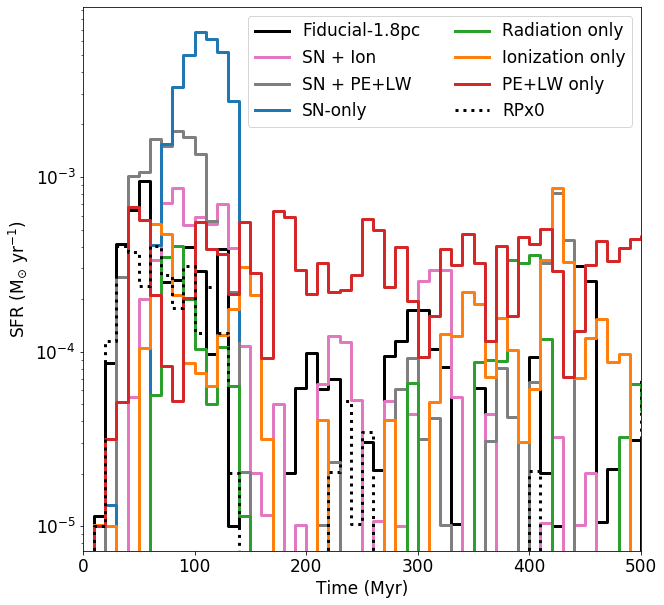

In [154]:
#
# plot a SFR comparison
#


fig, ax = plt.subplots()
fig.set_size_inches(10,10)

runs_to_plot = base_comparison
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].load_single('/time_data/time', index = -1) / 1.0E6
    SFR = all_data[run].load_single('/time_data/SFR',index = -1)
    
   # print(np.shape(t),np.shape(SFR[:-1])) 
    new_t = np.array(list(t) + [t[-1] + (t[-1]-t[-2])])

    t,SFR = utilities.simple_rebin(new_t-new_t[0], SFR, 10.0, method='average')    
    if run == 'fiducial':
        color = 'black'
    else:
        color = "C%0i"%(i)    
    ax.step(t[:-1], SFR, label = labels[run], lw = 3, where = 'post', color = colors[run], ls=lstyles[run])
    #ax.plot(t[:-1], SFR, label = labels[run], lw = 3, color = color)
    
ax.set_xlabel(r'Time (Myr)')
ax.set_ylabel(r'SFR (M$_{\odot}$ yr$^{-1}$)')
ax.semilogy()

ax.legend(loc='best',ncol = 2)

ax.set_xlim(0.0, 500.0)
#ax.set_ylim()

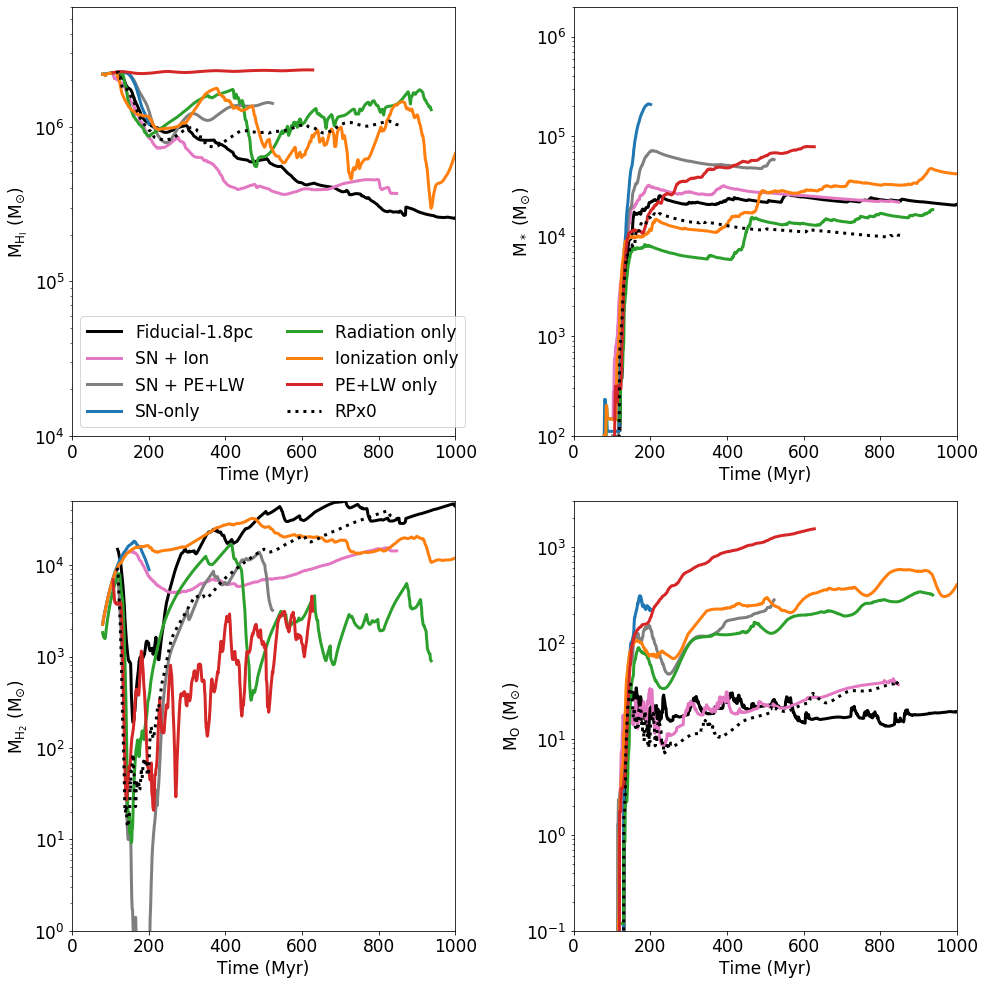

In [166]:
#
# plot a mass comparison
#


fig, axes = plt.subplots(2,2)
fs = 7
fig.set_size_inches(fs*2,fs*2)


ax_fields = ['M_HI','M_star','M_H2_total','M_O']
ax_labels = [r'M$_{\rm H_I}$ (M$_{\odot}$)', r'M$_{\rm *}$ (M$_{\odot}$)',
             r'M$_{\rm H_2}$ (M$_{\odot}$)', r'M$_{\rm O}$ (M$_{\odot}$)']
ylims = [ [1.0E4,6.0E6], [1.0E2,2.0E6], [1.0,5.0E4], [0.1,3000.0]]             

runs_to_plot = base_comparison


index = 0
axi = axj = 0
for ax1 in axes:
    
    axj = 0
    for ax2 in ax1:
        
        ax_index = (axi,axj)

        for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
       
            x = all_data[run].data('time')
            y = all_data[run].data(ax_fields[index])

            ax2.plot(x,y, label = labels[run], lw = 3, color = colors[run], ls = lstyles[run])

        ax2.set_ylabel(ax_labels[index])            
        ax2.set_xlabel(r'Time (Myr)')
        ax2.set_xlim(0.0,1000.0)
        ax2.semilogy()
        ax2.set_ylim(ylims[index])
        
        
        
        
        index = index + 1

        
             
        axj = axj + 1
        
    axi = axi + 1

axes[(0,0)].legend(loc='best',ncol=2)


plt.tight_layout()

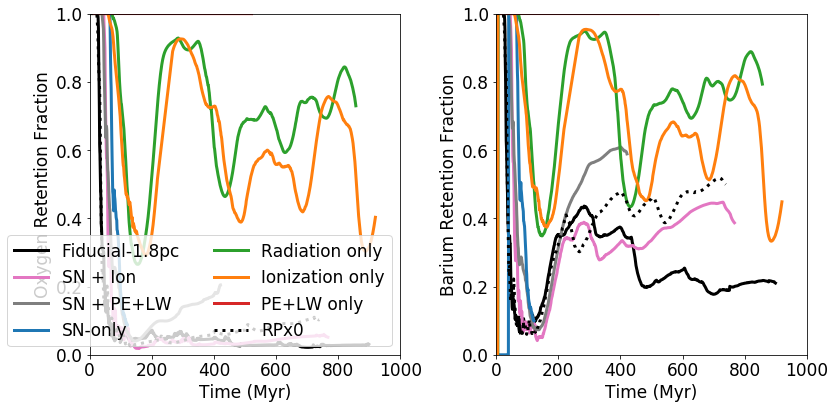

In [168]:
#
# plot a SFR comparison
#


fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)



runs_to_plot = base_comparison
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].data('time')
    t = t - t[0]
    
    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/O') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/O')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Disk/O')
    ax[0].plot(t, ( M_disk / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])

    M_tot = all_data[run].load_field('/gas_meta_data/masses/FullBox/Ba') +\
              all_data[run].load_field('/gas_meta_data/masses/OutsideBox/Ba')
    M_disk = all_data[run].load_field('/gas_meta_data/masses/Disk/Ba')
    ax[1].plot(t, (M_disk / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])    

for a in ax:
    a.set_xlabel(r'Time (Myr)')
    a.set_xlim(0.0, 1000.0)
    a.set_ylim(0.0, 1.0)    
ax[0].set_ylabel(r'Oxygen Retention Fraction')
ax[1].set_ylabel(r'Barium Retention Fraction')

#ax.semilogy()

ax[0].legend(loc='lower right',ncol = 2)

plt.tight_layout()
#ax.set_ylim()

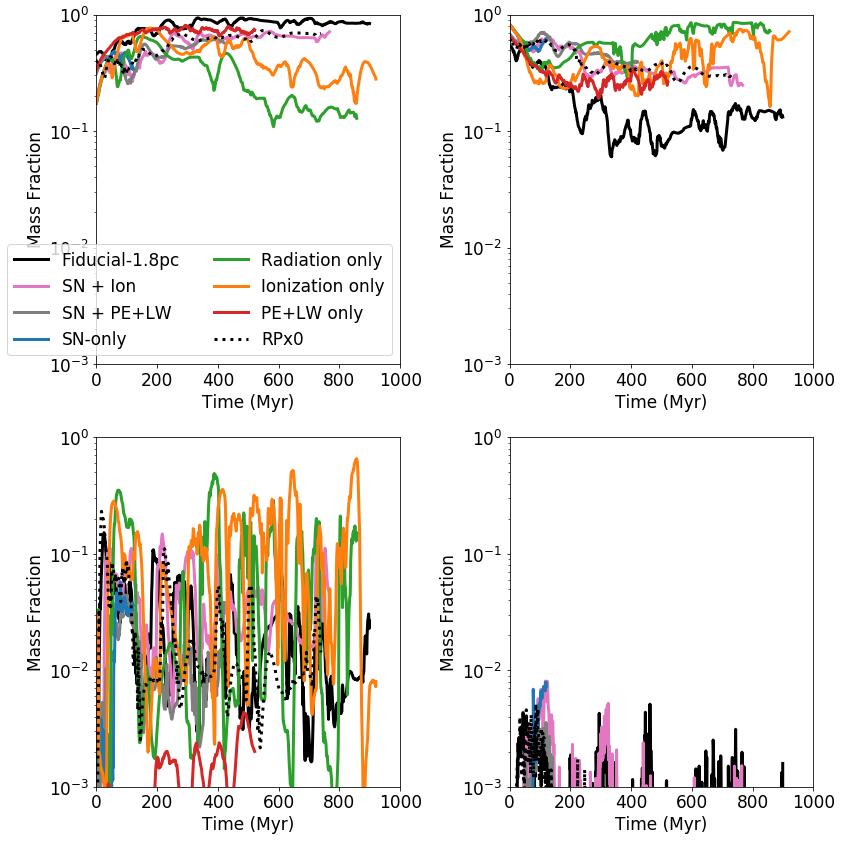

In [170]:
#
# plot a SFR comparison
#


fig, ax = plt.subplots(2,2)
fig.set_size_inches(12,12)



runs_to_plot = base_comparison
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].data('time')
    t = t - t[0]
    
    M_tot = all_data[run].load_field('/gas_meta_data/masses/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/masses/CNM/Total')
    ax[(0,0)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])

    M_tot = all_data[run].load_field('/gas_meta_data/masses/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/masses/WNM/Total')
    ax[(0,1)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    
    M_tot = all_data[run].load_field('/gas_meta_data/masses/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/masses/WIM/Total')
    ax[(1,0)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])  
    M_tot = all_data[run].load_field('/gas_meta_data/masses/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/masses/HIM/Total')
    ax[(1,1)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])      

for ax1 in ax:
    for a in ax1:
        a.set_xlabel(r'Time (Myr)')
        a.set_xlim(0.0, 1000.0)
        a.set_ylim(1.0E-3, 1.0)    
        a.semilogy()
        
        a.set_ylabel(r'Mass Fraction')

#ax.semilogy()

ax[(0,0)].legend(loc='lower right',ncol = 2)

plt.tight_layout()
#ax.set_ylim()

Failed more than 11 times loading with path /gas_meta_data/volume_fraction/Disk/Total and label /gas_meta_data/volume_fraction/Disk/Total


RuntimeError: 

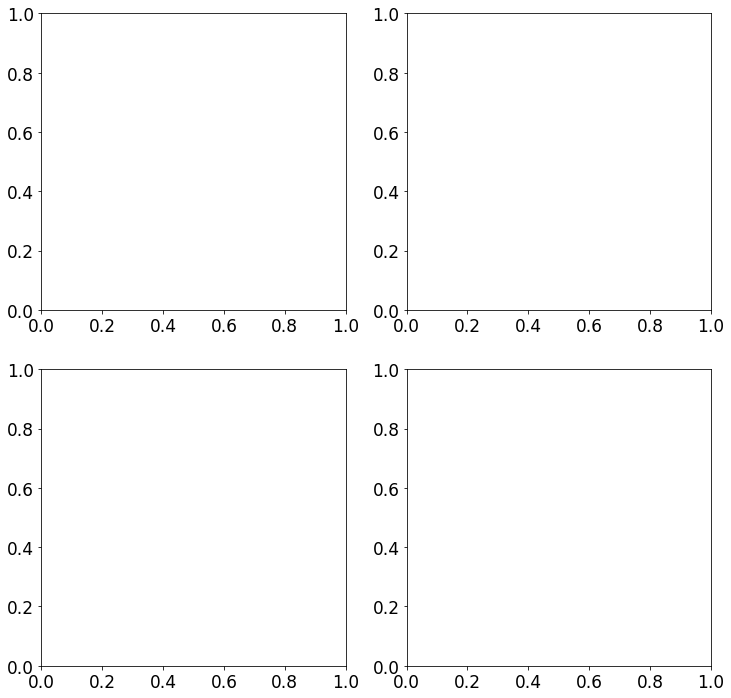

In [172]:
#
# plot a SFR comparison
#


fig, ax = plt.subplots(2,2)
fig.set_size_inches(12,12)



runs_to_plot = base_comparison
for i,run in enumerate(runs_to_plot):
    #t = all_data[run].data('time')
    
    #t = t - t[0]
    
    # _1 or #_100 for 1 Myr and 100 Myr averaged SFRs
    t   = all_data[run].data('time')
    t = t - t[0]
    
    M_tot = all_data[run].load_field('/gas_meta_data/volume_fraction/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/volume/CNM/Total')
    ax[(0,0)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])

    M_tot = all_data[run].load_field('/gas_meta_data/volume/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/volume/WNM/Total')
    ax[(0,1)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])
    
    M_tot = all_data[run].load_field('/gas_meta_data/volume/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/volume/WIM/Total')
    ax[(1,0)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])  
    M_tot = all_data[run].load_field('/gas_meta_data/volume/Disk/Total')
    M_phase = all_data[run].load_field('/gas_meta_data/volume/HIM/Total')
    ax[(1,1)].plot(t, ( M_phase / M_tot),
            label = labels[run], lw = 3, color = colors[run], ls=lstyles[run])      

for ax1 in ax:
    for a in ax1:
        a.set_xlabel(r'Time (Myr)')
        a.set_xlim(0.0, 1000.0)
        a.set_ylim(1.0E-3, 1.0)    
        a.semilogy()
        
        a.set_ylabel(r'Volume Fraction')

#ax.semilogy()

ax[(0,0)].legend(loc='lower right',ncol = 2)

plt.tight_layout()
#ax.set_ylim()